# AS.030.421 HW 5
## Sam Dawley
## Due: 10/11/2021

$\quad$ The first thing I'll do is define 3 functions that will help us with this analysis: `gaussian` is the most simple; it accepts a few parameters and will just return the probability density function of the normal distribution for us. It will be used extensively later when we start plotting best fit curves and estimating fit parameters. `spectrum_grapher` accepts a CSV file and plots $x,y$ data. It's best suited for UV/Vis data (because the axes are formatted for wavelength and absorbance) but in theory it can accept any sort of CSV file. Lastly is `spectrum_data`. Similar to `spectrum_grapher` it accepts a CSV file. In contrast, however, it doesn't plot anything and instead returns the relevant data we'll need for analysis later. Both are useful, just in different contexts.

In [1]:
import numpy as np
from math import sqrt

def gaussian(x, x_0, A, sigma):
    '''
    Parameters
    ----------
    A = area under curve
    sigma = scale parameter
    x_0 = location parameter
    x = array of number(s)
    
    Returns
    -------
    Probability of x given normal distribution with parameters above as an array
    '''
    return A/sigma/sqrt(2*np.pi)*np.exp(-np.power(x-x_0,2)/(2.0*sigma**2))

In [2]:
import csv
import matplotlib.pyplot as plt
import os

def spectrum_grapher(filename, c='k', alpha=1, size=1):
    '''
    This function accepts a CSV file containing absorbance data and plots wavelength versus absorbance.
    IMPORTANT: This script must be in the same directory as the folder containing the spectral data. 
    Ex// This jupyter notebook is in in the same folder as 'CTABSOS-Patman3'
    
    Parameters
    ----------
    filename = Name of csv file (with .csv at the end)
    
    Returns
    -------
    UV/Vis spectrum of data (matplotlib figure)
    '''
    # Begin by getting current working directory to find the filenames containing the spectral data
    cwd = os.getcwd()
    
    # Open the filename passed into the function
    # I copied the 'with' statement from a previous lecture
    with open(cwd + '/CTABSOS-Patman3/{}'.format(filename), 'r', newline = '') as csvfile:
        
        # Create a list of wavelengths and absorbances to be plotted later
        reader = csv.reader(csvfile, delimiter = ',', quotechar = '|')
        wavelengths = []; absorbances = []
        for row in reader:
            # x is wavelength, y is absorbance
            x = float(row[0]); y=float(row[1])
            wavelengths.append(x); absorbances.append(y)
        array = np.vstack((wavelengths, absorbances))
    
    # Plotting
    plt.scatter(array[0], array[1], s=size, color=c, label=filename.strip('.csv'), alpha=alpha)
        
    # Title the axes and create a legend
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    return 

In [3]:
import csv
import matplotlib.pyplot as plt
import os

def spectrum_data(filename):
    '''
    This function accepts a CSV file containing absorbance data and plots wavelength versus absorbance.
    IMPORTANT: This script must be in the same directory as the folder containing the spectral data. 
    Ex// This jupyter notebook is in in the same folder as 'CTABSOS-Patman3'
    
    Parameters
    ----------
    filename = Name of csv file (with .csv at the end)
    
    Returns
    -------
    spectrum_data[0] = array of wavelengths 
    spectrum_data[1] = array of absorbances
    spectrum_data[2] = wavelength corresponding to maximum absorbance 
    spectrum_data[3] = maximum absorbance 
    '''
    # Begin by getting current working directory to find the filenames containing the spectral data
    cwd = os.getcwd()
    
    # Open the filename passed into the function
    # I copied the 'with' statement from a previous lecture
    with open(cwd + '/CTABSOS-Patman3/{}'.format(filename), 'r', newline = '') as csvfile:
        
        # Create a list of wavelengths and absorbances to be plotted later
        reader = csv.reader(csvfile, delimiter = ',', quotechar = '|')
        wavelengths = []; absorbances = []
        for row in reader:
            # x is wavelength, y is absorbance
            x = float(row[0]); y=float(row[1])
            wavelengths.append(x); absorbances.append(y)
    return wavelengths, absorbances, wavelengths[absorbances.index(max(absorbances))], max(absorbances)

$\quad$ Here we'll stop to plot the data and get an idea for what's going on in the samples. All of the collected data is included, in addition to the spectral standards for vesicles, micells, and water. This data will be plotted again later to get a sense of how well the curve fitting works.

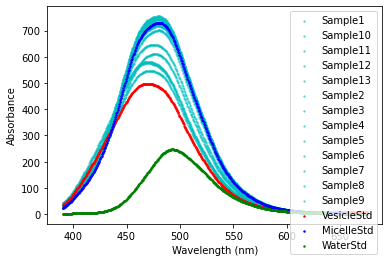

In [4]:
%matplotlib inline

# Get current working directory
cwd = os.getcwd()

# Get list of all spectral filenames in directory to iterate through and plot
files = os.listdir(cwd + '/CTABSOS-Patman3/')

# Create lists for each of the different types of data
# test_standards = the 3 test standards
# standards = the 3 spectral standards
# samples = the 13 sample spectra
test_standards = [name for name in files if 'TestStd' in name]
standards = [name for name in files if 'Std' in name and name not in test_standards]
samples = [name for name in files if 'Sample' in name]
samples.sort()

# Plotting
for name in samples:
    spectrum_grapher(name, c='c', alpha=0.5, size=2)
spectrum_grapher('VesicleStd.csv', c='r', size=2)
spectrum_grapher('MicelleStd.csv', c='b', size=2)
spectrum_grapher('WaterStd.csv', c='g', size=2)

plt.legend()

$\quad$ Now the analysis begins. In order to try and determine the composition of the samples from absorbtion data, we'll need to somehow fit a curve to the data and find the associated parameters for the curve. This isn't so bad as long as `scipy.optimize.curve_fit` is used in conjunction with the `gaussian` function we defined earlier. In theory we could have chosen any probability distribution to fit the data to, I suppose. However, the normal distribution is an excellent candidate for data fitting when we do not know the true distribution of the data because it appears immensely often in nature. In addition to that, if we collected a large number of data sets from the same sample and 'averaged' the fit parameters, the data would be roughly normal (this is the central limit theorem). Although that doesn't apply in this situation, it's another reason that the normal distribution is awesome.

$\quad$ The fit data is stored in the dictionary `best_fit_data` and is referenced often throughout the rest of the program. In addition to finding these parameters we plot the curves to see how well our estimate compares to the true shapes of the scatter plots above. I think we did a pretty good job.

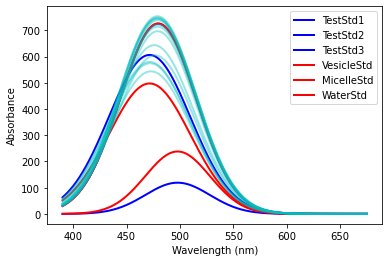

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import warnings

# Get current working directory
cwd = os.getcwd()

# Get list of all spectral filenames in directory to iterate through and plot
files = os.listdir(cwd + '/CTABSOS-Patman3/')

# Here we'll make create fit parameters for each of the sample data using the Gaussiun function defined above.
# Firstly I make some guesses at the parameters of the function to help curve_fit make an estimate. 
best_fit_data = {}
for f in files:
    # This filter is added because we don't really care about the covariance parameters since
    # all of the parameters we're interested in are measured independently of one another.
    warnings.filterwarnings('ignore', message='Covariance of the parameters could not be estimated')
    dt = spectrum_data(f)
    
    # The estimated center of the data is located at the wavelength corresponding to the maximum absorbance.
    # This wavelength has already been determined by the function spectrum_data
    est_center = dt[2]
    
    # The estimed standard deviation (or spread) of the data is found using an incredibly rough formula,
    # one-fourth of the range of the data
    est_std = (max(dt[1])-min(dt[1]))/4
    
    # The estimated area is found by integrating under the curve. Effectively, this area is used to scale
    # the fitted curves.
    est_area = trapezoid(dt[1], dt[0])
    
    # All of these parameters are stored in a dictionary
    best_fit_data[f] = curve_fit(gaussian, dt[0], dt[1], p0=[est_center, est_area, est_std])
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')

# Create lists for each of the different types of data and graph them
# test_standards = the 3 test standards
# standards = the 3 spectral standards
# samples = the 13 sample spectra
test_standards = ['TestStd1.csv', 'TestStd2.csv', 'TestStd3.csv']
for d in test_standards:
    x0, A, std = best_fit_data[d][0]
    plt.plot(spectrum_data(d)[0], 
             gaussian(spectrum_data(d)[0], x0, A, std), 
             c='b', lw=2, label=d.strip('.csv'))
    
standards = ['VesicleStd.csv', 'MicelleStd.csv', 'WaterStd.csv']
for d in standards:
    x0, A, std = best_fit_data[d][0]
    plt.plot(spectrum_data(d)[0], 
             gaussian(spectrum_data(d)[0], x0, A, std), 
             c='r', lw=2, label=d.strip('.csv'))

samples = [name for name in files if 'Sample' in name]
for d in samples:
    x0, A, std = best_fit_data[d][0]
    plt.plot(spectrum_data(d)[0], 
             gaussian(spectrum_data(d)[0], x0, A, std), 
             c='c', lw=2, alpha=0.4)
plt.legend()

$\quad$ Now the actual analysis part. This was the part that took me the longest. Not because coding it was hard (that part was relatively trivial), but because I could not for the life of me figure out how to determine the sample numbers of vesicles and micelles. Honestly still not sure I have the right answer but I felt like my idea was novel and at least gives a good approximation for the true sample numbers.

$\quad$ So how *can* we estimate the sample numbers? To do this, first recognize that we collected all of the spectral data above for a reason: If we can determine what 'percent' of each curve for the micelle, vesicle, and water standards goes into the curve for any given sample, we can say that this is the same percent as the percentage of micelles and vesicles in the sample. Thus, finding a linear combination of the fit parameters for the spectral standards is in order. Symbolically, we can say that

$$(\text{Sample Distrubution})=\lambda_1(\text{Micelle Distrubution})+\lambda_2(\text{Vesicle Distrubution})+\lambda_3(\text{Water Distrubution})$$

where $\lambda_1$, $\lambda_2$, and $\lambda_3$ are new parameters we need to solve for. *This is the new challenge*.
I also believe it's important to understand why we can just add the distributions together to afford the sample distribution. This is another beautiful aspect of the normal distribution: As an example, consider two random variables $U\sim\mathcal{N}(\mu_u,\sigma_u^2)$ and $V\sim\mathcal{N}(\mu_v,\sigma_v^2)$. Then, their sum $X=\alpha U+\beta V$ is *also* a normally distributed random variable whose distribution is given by

$$X\sim\mathcal{N}(\alpha\mu_u+\beta\mu_v,\alpha^2\sigma_u^2+\beta^2\sigma_v^2)$$

That's the intuition behind why we're 'allowed' to take their sum. Awesome! Back to the problem at hand.

$\quad$ Seemingly, we're given a single system of equations with 3 unknowns. However, let's keep in mind that we're dealing with a physical system and that there are implicit restrictions on what $\lambda_1$, $\lambda_2$, and $\lambda_3$ can be. Firstly, they must all be nonnegative so that $\lambda_1,\lambda_2,\lambda_3\geq0$. Moreover, the linear combination of $\lambda_1$, $\lambda_2$, and $\lambda_3$ is a *convex combination* so that

$$\lambda_1+\lambda_2+\lambda_3=1$$

Finally, in order to institute the inequality constraints described above we'll convert this system to a linear program. In addition to the constraints above our objective function will take the form

$$\lambda_3-\lambda_1-\lambda_2$$

$\quad$ Intuitively, we'll be trying to minimize the function above because it will give us values for $\lambda_1$ and $\lambda_2$ which will *be our sample numbers*. Recall that $\lambda_1$, $\lambda_2$, and $\lambda_3$ are coefficients for the distribution of micelles, vesicles, and water, respectively. Thus, by minimizing $\lambda_3$ (to zero, in fact), we're given the ratio of micelles to vesicles, i.e., $\lambda_1:\lambda_2$ is the ratio of micelles to vesicles.

$\quad$ In summary, to find the sample numbers of micells and vesicles in the sample we'll be interested in solving the following linear program:

\begin{align*}
\phantom{(LP) }\text{minimize }\quad & \lambda_3-\lambda_1-\lambda_2 \\
\phantom{(LP) }\text{subject to }\quad & \lambda_1+\lambda_2+\lambda_3=1 \\
\phantom{(LP) subject to }\quad & A_1\lambda_1+A_2\lambda_2+A_3\lambda_3=A \\
\phantom{(LP) subject to }\quad & \lambda_1,\lambda_2,\lambda_3\geq0
\end{align*}

$\quad$ Implementing an algorithm to run through this calculation seemed daunting, at first. I was worried for a moment that I would have to code the Simplex algorithm. Luckily (and unsurprisingly), there was already a python library that would do this for me, `scipy.linalg.linprog`. Then, all we have to do is setup the constraints. Below I printed all of the sample numbers that this algorithm popped out.

In [6]:
%matplotlib inline
from scipy.optimize import linprog

# First establish the fit parameters we found above to refer back to later
micelle_fit = best_fit_data['MicelleStd.csv']
vesicle_fit = best_fit_data['VesicleStd.csv']
water_fit = best_fit_data['WaterStd.csv']

# Now we'll start to build the system of equations which will define the linear program
# Building the constraint library
constraints = {}
for f in samples:
    temp = best_fit_data[f]
    constraints[f] = [temp[0][0], temp[0][1], temp[0][2]]
 
# Creating a list of the constraints put in place by the areas under the curves of the 
# Micelles, Vesicles, and Water
area_constraints = [micelle_fit[0][1], vesicle_fit[0][1], water_fit[0][1]]

# Bringing together the lists we defined above into larger arrays (the matrices depicted above)
# X_sys represents the equality constraints, X_inq represents inequality constraints
A_sys = [[1, 1, 1], area_constraints] 
A_inq = [[-1, 0, 0], [0, -1, 0], [0, 0, -1]]
b_inq = [0, 0, 0]
convex_combinations = {}
for f in samples:
    temp = best_fit_data[f]
    b_sys = [1, temp[0][1]]
    convex_combinations[f] = linprog(c=[1, -1, -1], A_eq=A_sys, A_ub=A_inq, b_eq=b_sys, b_ub=b_inq)
    
# Printing the data collected using linprog
for i in samples:
    print('{2} Sample Numbers\nMicelle = {0:0.4f}\nVesicle = {1:0.4f}\n'.format(
        convex_combinations[i].x[0], convex_combinations[i].x[1], i.strip('.csv')))

Sample4 Sample Numbers
Micelle = 0.7349
Vesicle = 0.2651

Sample5 Sample Numbers
Micelle = 0.4697
Vesicle = 0.5303

Sample7 Sample Numbers
Micelle = 1.0098
Vesicle = 0.2105

Sample6 Sample Numbers
Micelle = 1.0097
Vesicle = 0.2369

Sample2 Sample Numbers
Micelle = 0.4019
Vesicle = 0.5981

Sample3 Sample Numbers
Micelle = 0.2145
Vesicle = 0.7855

Sample1 Sample Numbers
Micelle = 0.4471
Vesicle = 0.5529

Sample11 Sample Numbers
Micelle = 0.8589
Vesicle = 0.1411

Sample10 Sample Numbers
Micelle = 0.9656
Vesicle = 0.0344

Sample12 Sample Numbers
Micelle = 0.9914
Vesicle = 0.0086

Sample13 Sample Numbers
Micelle = 0.9904
Vesicle = 0.1399

Sample8 Sample Numbers
Micelle = 1.0089
Vesicle = 0.1857

Sample9 Sample Numbers
Micelle = 1.0094
Vesicle = 0.2568



$\quad$ Recall that the sample numbers are supposed to be *proportions of the sample*. So, they should be on the unit interval. To remedy the discrepancy between this fact and the 'sample numbers' collected above we'll simply sum the parameters and find the weighted averages for the micelles and vesicles. Our final answers for the sample numbers are reported below, as well as the scaled micelle and vesicle spectra which form the linear combination of the sample distribution.

Sample4 Sample Numbers
Micelle = 0.7349
Vesicle = 0.2651

Sample5 Sample Numbers
Micelle = 0.4697
Vesicle = 0.5303

Sample7 Sample Numbers
Micelle = 0.8275
Vesicle = 0.1725

Sample6 Sample Numbers
Micelle = 0.8100
Vesicle = 0.1900

Sample2 Sample Numbers
Micelle = 0.4019
Vesicle = 0.5981

Sample3 Sample Numbers
Micelle = 0.2145
Vesicle = 0.7855

Sample1 Sample Numbers
Micelle = 0.4471
Vesicle = 0.5529

Sample11 Sample Numbers
Micelle = 0.8589
Vesicle = 0.1411

Sample10 Sample Numbers
Micelle = 0.9656
Vesicle = 0.0344

Sample12 Sample Numbers
Micelle = 0.9914
Vesicle = 0.0086

Sample13 Sample Numbers
Micelle = 0.8762
Vesicle = 0.1238

Sample8 Sample Numbers
Micelle = 0.8446
Vesicle = 0.1554

Sample9 Sample Numbers
Micelle = 0.7972
Vesicle = 0.2028



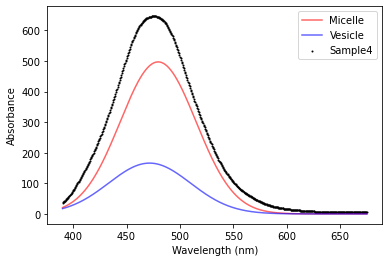

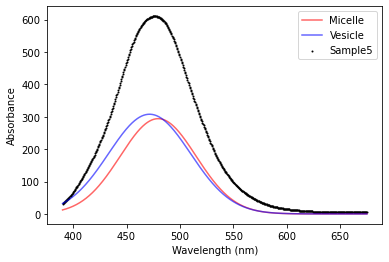

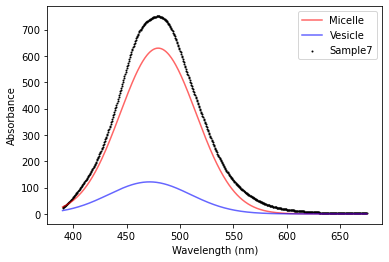

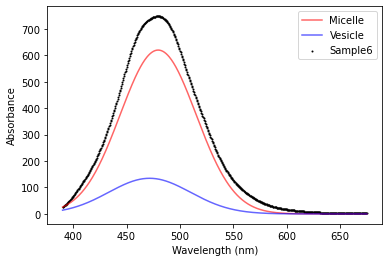

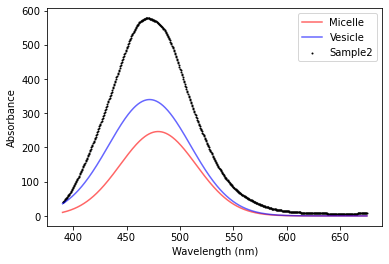

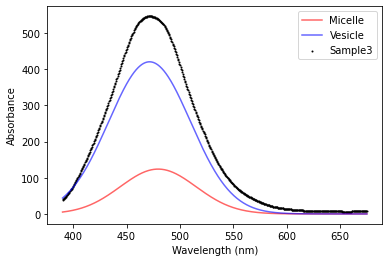

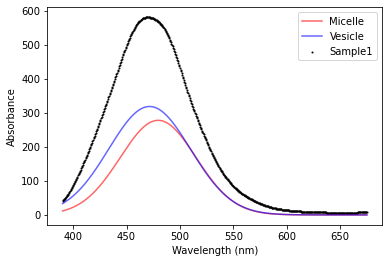

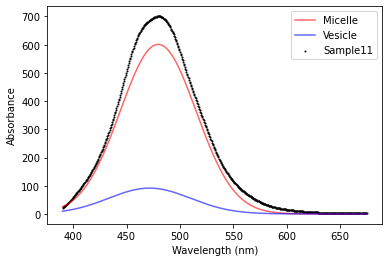

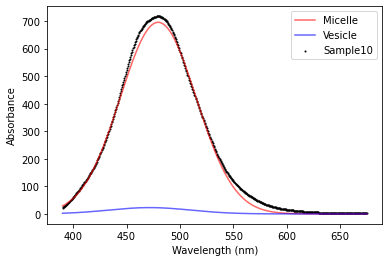

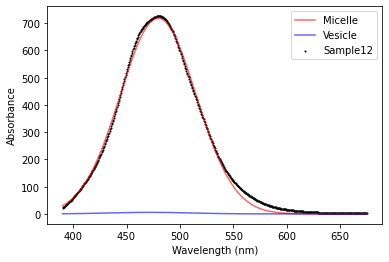

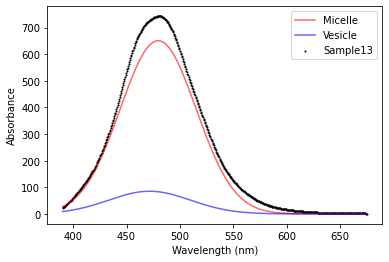

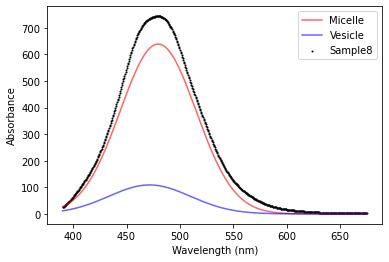

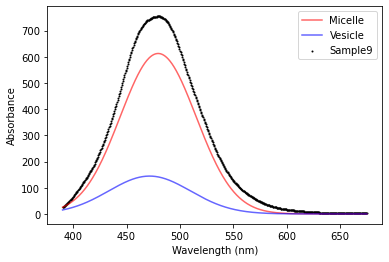

In [7]:
for i in samples:
        prop_m, prop_v = convex_combinations[i].x[0], convex_combinations[i].x[1]
        tot = prop_m + prop_v
        print('{2} Sample Numbers\nMicelle = {0:0.4f}\nVesicle = {1:0.4f}\n'.format(
            prop_m/tot, prop_v/tot, i.strip('.csv')))
        plt.figure()
        spectrum_grapher(i, c='k', alpha=1)
        plt.plot(spectrum_data('MicelleStd.csv')[0], gaussian(spectrum_data(i)[0],
                                           best_fit_data['MicelleStd.csv'][0][0],
                                           prop_m/tot * best_fit_data[i][0][1],
                                           best_fit_data['MicelleStd.csv'][0][2]), 
                                           c='r', alpha=0.6, label='Micelle')
        plt.plot(spectrum_data('VesicleStd.csv')[0], gaussian(spectrum_data(i)[0],
                                           best_fit_data['VesicleStd.csv'][0][0],
                                           prop_v/tot * best_fit_data[i][0][1],
                                           best_fit_data['VesicleStd.csv'][0][2]),
                                           c='b', alpha=0.6, label='Vesicle')
        plt.legend()